# Import Stuff & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
RESOLUTION = 64
block_frame = 9
frame_interval = 5

In [5]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    # transforms.Lambda(lambda x: x / 255.),
    transforms.Resize((RESOLUTION, RESOLUTION))
])


# Utils

In [7]:
def plot_image_from_list(__images, __labels, __count):
    plt.figure(figsize=(10, 10))
    for _i in range(__count[0] * __count[1]):
        plt.subplot(__count[0], __count[1], _i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        _img = __images[_i].to("cpu").numpy()
        plt.imshow(_img, cmap= "gray")
        plt.xlabel(__labels[_i])
    plt.show()

In [8]:
def plot_randomly_form_dataset(__dataset):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        
        

In [9]:
plot_randomly_form_dataset(train_dataset)
print(train_dataset._labels)

NameError: name 'train_dataset' is not defined

In [23]:
def plot_sequence_form_dataset(__dataset, index):
    images = []
    labels = []
    for i in range(0, block_frame):
        image, label = __dataset[index]
        images.append(image.squeeze())
        labels.append(__dataset.label_id2str(label.item()))
    
    plot_image_from_list(images, labels, (1, block_frame))
        

In [61]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(0, 25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        result = model(image).squeeze().cpu().argmax()
        
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))
    
    plot_image_from_list(images, labels, (5, 5))
        
        

# Dataset

In [12]:
DATA_SOURCE = {
    "Abuse": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-1\Anomaly-Videos-Part-1\Abuse",
    "Arrest": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-1\Anomaly-Videos-Part-1\Arrest",
    "Arson": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-1\Anomaly-Videos-Part-1\Arson",
    "Assault": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-1\Anomaly-Videos-Part-1\Assault",
    "Burglary": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-2\Anomaly-Videos-Part-2\Burglary",
    "Explosion": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-2\Anomaly-Videos-Part-2\Explosion",
    "Fighting": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-2\Anomaly-Videos-Part-2\Fighting",   
    "RoadAccidents":r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-3\Anomaly-Videos-Part-3\RoadAccidents",
    "Robbery": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-3\Anomaly-Videos-Part-3\Robbery",
    "Shooting": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-3\Anomaly-Videos-Part-3\Shooting",
    "Shoplifting": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-4\Anomaly-Videos-Part-4\Shoplifting",
    "Stealing": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-4\Anomaly-Videos-Part-4\Stealing",
    "Vandalism": r"D:\Anomaly-Detection-Dataset\Anomaly-Videos-Part-4\Anomaly-Videos-Part-4\Vandalism",
    "Normal": r"D:\Anomaly-Detection-Dataset\Training-Normal-Videos-Part-1\Training-Normal-Videos-Part-1"
   
}





# DATA_SOURCE = {
#     "Abuse": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Abuse",
#     "Arrest": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Arrest",
#     "Arson": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Arson",
#     "Assault": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Assault",
#     "Burglary": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Burglary",
#     "Explosion": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Explosion",
#     "Fighting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Fighting",   
#     "RoadAccidents":"D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\RoadAccidents",
#     "Robbery": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Robbery",
#     "Shooting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Shooting",
#     "Shoplifting": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Shoplifting",
#     "Stealing": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Stealing",
#     "Vandalism": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Vandalism",
#     "Normal": "D:\\Anomaly-Detection-Dataset\\Miniset_for_train_1\\Normal"
# }


# DATA_SOURCE = {
#        "Abuse": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-1/Anomaly-Videos-Part-1/Abuse",
#     "Arrest": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-1/Anomaly-Videos-Part-1/Arrest",
#     "Arson": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-1/Anomaly-Videos-Part-1/Arson",
#     "Assault": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-1/Anomaly-Videos-Part-1/Assault",
#     "Burglary": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-2/Anomaly-Videos-Part-2/Burglary",
#     "Explosion": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-2/Anomaly-Videos-Part-2/Explosion",
#     "Fighting": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-2/Anomaly-Videos-Part-2/Fighting",   
#     "RoadAccidents":"/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/RoadAccidents",
#     "Robbery": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/Robbery",
#     "Shooting": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-3/Anomaly-Videos-Part-3/Shooting",
#     "Shoplifting": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Shoplifting",
#     "Stealing": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Stealing",
#     "Vandalism": "/home/yhwoo7/Anomaly-Detection-Dataset/Anomaly-Videos-Part-4/Anomaly-Videos-Part-4/Vandalism",
#     "Normal": "/home/yhwoo7/Anomaly-Detection-Dataset/Training-Normal-Videos-Part-1/Training-Normal-Videos-Part-1"
# }




In [13]:
import numpy as np
txt_train = "D:\Anomaly-Detection-Dataset\supermini_train.txt"
train_dic = {}
with open(txt_train, 'r') as file:
    for line in file:
        parts = line.strip().split('/')
        # print(parts)
        train_dic[parts[1]] = parts[0]
    
txt_test = "D:\Anomaly-Detection-Dataset\supermini_test.txt"
test_dic = {}
with open(txt_test, 'r') as file:
    for line in file:
        parts = line.strip().split()
        video_name = parts[0]
        event_name = parts[1]
        start_frame1 = int(parts[2])
        end_frame1 = int(parts[3])
        start_frame2 = int(parts[4])
        end_frame2 = int(parts[5])
        test_dic[video_name] = [event_name, start_frame1, end_frame1, start_frame2, end_frame2]


In [14]:
import os
for directory_path in DATA_SOURCE.items():
# 경로가 존재하는지 확인합니다.
    if os.path.exists(directory_path[1]):
        print("경로가 존재합니다.")
        # 디렉터리 내의 파일 목록을 출력합니다.
        print("디렉터리 내용:", os.listdir(directory_path[1]))
    else:
        print("지정된 경로를 찾을 수 없습니다.")


경로가 존재합니다.
디렉터리 내용: ['Abuse001_x264.mp4', 'Abuse002_x264.mp4', 'Abuse003_x264.mp4', 'Abuse004_x264.mp4', 'Abuse005_x264.mp4', 'Abuse006_x264.mp4', 'Abuse007_x264.mp4', 'Abuse008_x264.mp4', 'Abuse009_x264.mp4', 'Abuse010_x264.mp4', 'Abuse011_x264.mp4', 'Abuse012_x264.mp4', 'Abuse013_x264.mp4', 'Abuse014_x264.mp4', 'Abuse015_x264.mp4', 'Abuse016_x264.mp4', 'Abuse017_x264.mp4', 'Abuse018_x264.mp4', 'Abuse019_x264.mp4', 'Abuse020_x264.mp4', 'Abuse021_x264.mp4', 'Abuse022_x264.mp4', 'Abuse023_x264.mp4', 'Abuse024_x264.mp4', 'Abuse025_x264.mp4', 'Abuse026_x264.mp4', 'Abuse027_x264.mp4', 'Abuse028_x264.mp4', 'Abuse029_x264.mp4', 'Abuse030_x264.mp4', 'Abuse031_x264.mp4', 'Abuse032_x264.mp4', 'Abuse033_x264.mp4', 'Abuse034_x264.mp4', 'Abuse035_x264.mp4', 'Abuse036_x264.mp4', 'Abuse037_x264.mp4', 'Abuse038_x264.mp4', 'Abuse039_x264.mp4', 'Abuse040_x264.mp4', 'Abuse041_x264.mp4', 'Abuse042_x264.mp4', 'Abuse043_x264.mp4', 'Abuse044_x264.mp4', 'Abuse045_x264.mp4', 'Abuse046_x264.mp4', 'Abuse047_x26

In [15]:
class CrimeDataset(Dataset):
    train = True
    def __init__(self, __train=True):
        train = __train
        self._data = []
        self._labels = []
        self._frame_interval = frame_interval
        
        print(f"Loading {'train' if train else 'test' } dataset...")

        if train:
            for label, data_path in DATA_SOURCE.items():
                print(f"Loading Label {label}...")
            
                for file in tqdm(os.listdir(data_path)):
                    if file.endswith(".mp4") and file in train_dic:
                        path = os.path.join(data_path, file)
                        data, labels = self._parse_file(path, label)
                        self._data.extend(data)
                        self._labels.extend(labels)
        else:
            for label, data_path in DATA_SOURCE.items():
                print(f"Loading Label {label}...")
            
                for file in tqdm(os.listdir(data_path)):
                    if file.endswith(".mp4") and file in test_dic:
                        path = os.path.join(data_path, file)
                        data, labels = self._parse_file(path, label)
                        self._data.extend(data)
                        self._labels.extend(labels)
                    
        print(f"Finished loading {'train' if train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, __path, __label):
        if not os.path.exists(__path):
            return [], []
        
        data = []
        labels = []
        frame_count = 0
        cap = cv2.VideoCapture(__path)
        success, image = cap.read()
        while success:
            try:
                if True:
                    
                    if train:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                        Y, U, V = cv2.split(image)
                        image = transformer(Y)
                        data.append(image)
                        labels.append(__label) 
                                
                    else:
                        data.append(image)
                        filepath_list = __path.split('\\')
                        event_name, start_frame1, end_frame1, start_frame2, end_frame2 = test_dic[filepath_list[-1]]
                        if (frame_count >= start_frame1 and frame_count <= end_frame1) or (frame_count >= start_frame2 and frame_count <= end_frame2):
                            labels.append(__label)
                        else:
                            labels.append("Normal")
                    
                
            except Exception as e:
                print(f"Error loading file {__path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1 
        return data, labels
        
    
    def label_str2id(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(__label)

    def label_id2str(self, __label):
        labels = DATA_SOURCE.keys()
        return list(labels)[__label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, __idx):
        data = self._data[__idx]
        label = self._labels[__idx]
        return data, torch.tensor([self.label_str2id(label)])

In [16]:
train = True
train_dataset = CrimeDataset(True)
train = False
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Abuse...


100%|██████████| 50/50 [00:05<00:00,  8.60it/s]


Loading Label Arrest...


100%|██████████| 50/50 [00:03<00:00, 16.04it/s]


Loading Label Arson...


100%|██████████| 50/50 [00:01<00:00, 34.35it/s]


Loading Label Assault...


100%|██████████| 50/50 [00:02<00:00, 18.51it/s]


Loading Label Burglary...


100%|██████████| 100/100 [00:02<00:00, 42.83it/s]


Loading Label Explosion...


100%|██████████| 50/50 [00:00<00:00, 89.49it/s]


Loading Label Fighting...


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


Loading Label RoadAccidents...


100%|██████████| 150/150 [00:00<00:00, 156.07it/s]


Loading Label Robbery...


100%|██████████| 150/150 [00:01<00:00, 106.20it/s]


Loading Label Shooting...


100%|██████████| 50/50 [00:02<00:00, 23.81it/s]


Loading Label Shoplifting...


100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


Loading Label Stealing...


100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


Loading Label Vandalism...


100%|██████████| 50/50 [00:01<00:00, 36.56it/s]


Loading Label Normal...


100%|██████████| 800/800 [00:02<00:00, 352.10it/s]


Finished loading train dataset... Loaded  28104 images.
Loading test dataset...
Loading Label Abuse...


100%|██████████| 50/50 [00:00<00:00, 130.27it/s]


Loading Label Arrest...


100%|██████████| 50/50 [00:00<00:00, 50075.26it/s]


Loading Label Arson...


100%|██████████| 50/50 [00:00<00:00, 109.48it/s]


Loading Label Assault...


100%|██████████| 50/50 [00:02<00:00, 17.26it/s]


Loading Label Burglary...


100%|██████████| 100/100 [00:01<00:00, 74.00it/s]


Loading Label Explosion...


100%|██████████| 50/50 [00:02<00:00, 21.81it/s]


Loading Label Fighting...


100%|██████████| 50/50 [00:00<?, ?it/s]


Loading Label RoadAccidents...


100%|██████████| 150/150 [00:00<?, ?it/s]


Loading Label Robbery...


100%|██████████| 150/150 [00:00<?, ?it/s]


Loading Label Shooting...


100%|██████████| 50/50 [00:00<?, ?it/s]


Loading Label Shoplifting...


100%|██████████| 50/50 [00:00<00:00, 91.65it/s]


Loading Label Stealing...


100%|██████████| 100/100 [00:00<00:00, 102.93it/s]


Loading Label Vandalism...


100%|██████████| 50/50 [00:00<00:00, 69.61it/s] 


Loading Label Normal...


100%|██████████| 800/800 [00:00<?, ?it/s]

Finished loading test dataset... Loaded  15435 images.


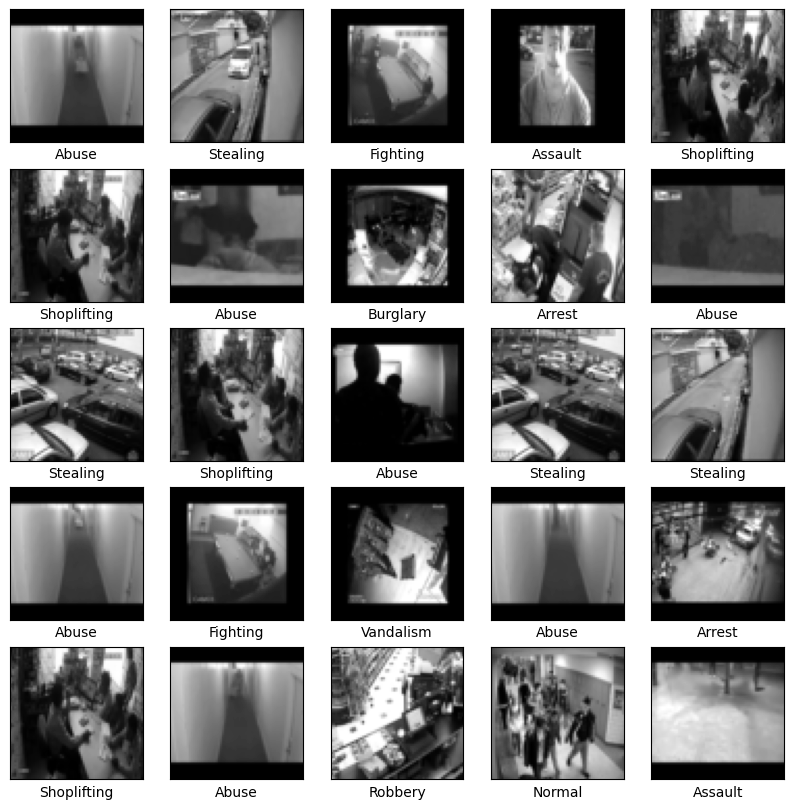

In [17]:
plot_randomly_form_dataset(train_dataset)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

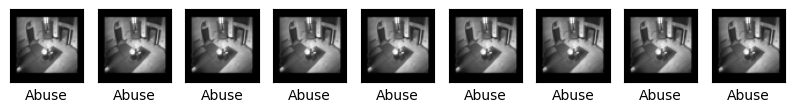

In [24]:

plot_sequence_form_dataset(train_dataset, 4)

# Model

In [42]:
from typing import Any, Callable, Dict, List, Mapping, Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F


def make_divisible(
        value: float,
        divisor: int,
        min_value: Optional[float] = None,
        round_down_protect: bool = True,
    ) -> int:
    """
    This function is copied from here 
    "https://github.com/tensorflow/models/blob/master/official/vision/modeling/layers/nn_layers.py"
    
    This is to ensure that all layers have channels that are divisible by 8.

    Args:
        value: A `float` of original value.
        divisor: An `int` of the divisor that need to be checked upon.
        min_value: A `float` of  minimum value threshold.
        round_down_protect: A `bool` indicating whether round down more than 10%
        will be allowed.

    Returns:
        The adjusted value in `int` that is divisible against divisor.
    """
    if min_value is None:
        min_value = divisor
    new_value = max(min_value, int(value + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if round_down_protect and new_value < 0.9 * value:
        new_value += divisor
    return int(new_value)
def conv_2d(inp, oup, kernel_size=3, stride=1, groups=1, bias=False, norm=True, act=True):
    conv = nn.Sequential()
    padding = (kernel_size - 1) // 2
    conv.add_module('conv', nn.Conv2d(inp, oup, kernel_size, stride, padding, bias=bias, groups=groups))
    if norm:
        conv.add_module('BatchNorm2d', nn.BatchNorm2d(oup))
    if act:
        conv.add_module('Activation', nn.ReLU6())
    return conv


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, act=False, squeeze_excitation=False):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        hidden_dim = int(round(inp * expand_ratio))
        self.block = nn.Sequential()
        if expand_ratio != 1:
            self.block.add_module('exp_1x1', conv_2d(inp, hidden_dim, kernel_size=3, stride=stride))
        if squeeze_excitation:
            self.block.add_module('conv_3x3', conv_2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, groups=hidden_dim))
        self.block.add_module('red_1x1', conv_2d(hidden_dim, oup, kernel_size=1, stride=1, act=act))
        self.use_res_connect = self.stride == 1 and inp == oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class UniversalInvertedBottleneckBlock(nn.Module):
    def __init__(self, 
            inp, 
            oup, 
            start_dw_kernel_size, 
            middle_dw_kernel_size, 
            middle_dw_downsample,
            stride,
            expand_ratio
        ):
        """An inverted bottleneck block with optional depthwises.
        Referenced from here https://github.com/tensorflow/models/blob/master/official/vision/modeling/layers/nn_blocks.py
        """
        super().__init__()
        # Starting depthwise conv.
        self.start_dw_kernel_size = start_dw_kernel_size
        if self.start_dw_kernel_size:            
            stride_ = stride if not middle_dw_downsample else 1
            self._start_dw_ = conv_2d(inp, inp, kernel_size=start_dw_kernel_size, stride=stride_, groups=inp, act=False)
        # Expansion with 1x1 convs.
        expand_filters = make_divisible(inp * expand_ratio, 8)
        self._expand_conv = conv_2d(inp, expand_filters, kernel_size=1)
        # Middle depthwise conv.
        self.middle_dw_kernel_size = middle_dw_kernel_size
        if self.middle_dw_kernel_size:
            stride_ = stride if middle_dw_downsample else 1
            self._middle_dw = conv_2d(expand_filters, expand_filters, kernel_size=middle_dw_kernel_size, stride=stride_, groups=expand_filters)
        # Projection with 1x1 convs.
        self._proj_conv = conv_2d(expand_filters, oup, kernel_size=1, stride=1, act=False)
        
        # Ending depthwise conv.
        # this not used
        # _end_dw_kernel_size = 0
        # self._end_dw = conv_2d(oup, oup, kernel_size=_end_dw_kernel_size, stride=stride, groups=inp, act=False)
        
    def forward(self, x):
        if self.start_dw_kernel_size:
            x = self._start_dw_(x)
            # print("_start_dw_", x.shape)
        x = self._expand_conv(x)
        # print("_expand_conv", x.shape)
        if self.middle_dw_kernel_size:
            x = self._middle_dw(x)
            # print("_middle_dw", x.shape)
        x = self._proj_conv(x)
        # print("_proj_conv", x.shape)
        return x

class MultiQueryAttentionLayerWithDownSampling(nn.Module):
    def __init__(self, inp, num_heads, key_dim, value_dim, query_h_strides, query_w_strides, kv_strides, dw_kernel_size=3, dropout=0.0):
        """Multi Query Attention with spatial downsampling.
        Referenced from here https://github.com/tensorflow/models/blob/master/official/vision/modeling/layers/nn_blocks.py

        3 parameters are introduced for the spatial downsampling:
        1. kv_strides: downsampling factor on Key and Values only.
        2. query_h_strides: vertical strides on Query only.
        3. query_w_strides: horizontal strides on Query only.

        This is an optimized version.
        1. Projections in Attention is explict written out as 1x1 Conv2D.
        2. Additional reshapes are introduced to bring a up to 3x speed up.
        """
        super().__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.query_h_strides = query_h_strides
        self.query_w_strides = query_w_strides
        self.kv_strides = kv_strides
        self.dw_kernel_size = dw_kernel_size
        self.dropout = dropout

        self.head_dim = key_dim // num_heads

        if self.query_h_strides > 1 or self.query_w_strides > 1:
            self._query_downsampling_norm = nn.BatchNorm2d(inp)
        self._query_proj = conv_2d(inp, num_heads*key_dim, 1, 1, norm=False, act=False)
        
        if self.kv_strides > 1:
            self._key_dw_conv = conv_2d(inp, inp, dw_kernel_size, kv_strides, groups=inp, norm=True, act=False)
            self._value_dw_conv = conv_2d(inp, inp, dw_kernel_size, kv_strides, groups=inp, norm=True, act=False)
        self._key_proj = conv_2d(inp, key_dim, 1, 1, norm=False, act=False)
        self._value_proj = conv_2d(inp, key_dim, 1, 1, norm=False, act=False)

        self._output_proj = conv_2d(num_heads*key_dim, inp, 1, 1, norm=False, act=False)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        batch_size, seq_length, _, _ = x.size()
        if self.query_h_strides > 1 or self.query_w_strides > 1:
            q = F.avg_pool2d(self.query_h_stride, self.query_w_stride)
            q = self._query_downsampling_norm(q)
            q = self._query_proj(q)
        else:
            q = self._query_proj(x)
        px = q.size(2)
        q = q.view(batch_size, self.num_heads, -1, self.key_dim) # [batch_size, num_heads, seq_length, key_dim]

        if self.kv_strides > 1:
            k = self._key_dw_conv(x)
            k = self._key_proj(k)
            v = self._value_dw_conv(x)
            v = self._value_proj(v)          
        else:
            k = self._key_proj(x)
            v = self._value_proj(x)
        k = k.view(batch_size, 1, self.key_dim, -1) # [batch_size, 1, key_dim, seq_length]
        v = v.view(batch_size, 1, -1, self.key_dim) # [batch_size, 1, seq_length, key_dim]

        # calculate attn score
        attn_score = torch.matmul(q, k) / (self.head_dim ** 0.5)
        attn_score = self.dropout(attn_score)
        attn_score = F.softmax(attn_score, dim=-1)

        context = torch.matmul(attn_score, v)
        context = context.view(batch_size, self.num_heads * self.key_dim, px, px)
        output = self._output_proj(context)
        return output

class MNV4LayerScale(nn.Module):
    def __init__(self, inp, init_value):
        """LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239
        Referenced from here https://github.com/tensorflow/models/blob/master/official/vision/modeling/layers/nn_blocks.py
        
        As used in MobileNetV4.

        Attributes:
            init_value (float): value to initialize the diagonal matrix of LayerScale.
        """
        super().__init__()
        self.init_value = init_value
        self._gamma = nn.Parameter(self.init_value * torch.ones(inp, 1, 1))
    
    def forward(self, x):
        return x * self._gamma

class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(
            self, 
            inp,
            num_heads, 
            key_dim,  
            value_dim, 
            query_h_strides, 
            query_w_strides, 
            kv_strides,
            use_layer_scale,
            use_multi_query, 
            use_residual = True
        ):
        super().__init__()
        self.query_h_strides = query_h_strides
        self.query_w_strides = query_w_strides
        self.kv_strides = kv_strides
        self.use_layer_scale = use_layer_scale
        self.use_multi_query = use_multi_query
        self.use_residual = use_residual

        self._input_norm = nn.BatchNorm2d(inp)
        if self.use_multi_query:
            self.multi_query_attention = MultiQueryAttentionLayerWithDownSampling(
                inp, num_heads, key_dim, value_dim, query_h_strides, query_w_strides, kv_strides
            )
        else:
            self.multi_head_attention = nn.MultiheadAttention(inp, num_heads, kdim=key_dim)
        
        if self.use_layer_scale:
            self.layer_scale_init_value = 1e-5
            self.layer_scale = MNV4LayerScale(inp, self.layer_scale_init_value) 
    
    def forward(self, x):
        # Not using CPE, skipped
        # input norm
        shortcut = x
        x = self._input_norm(x)
        # multi query
        if self.use_multi_query:
            x = self.multi_query_attention(x)
        else:
            x = self.multi_head_attention(x, x)
        # layer scale
        if self.use_layer_scale:
            x = self.layer_scale(x)
        # use residual
        if self.use_residual:
            x = x + shortcut
        return x

def build_blocks(layer_spec):
    if not layer_spec.get('block_name'):
        return nn.Sequential()
    block_names = layer_spec['block_name']
    layers = nn.Sequential()
    if block_names == "convbn":
        schema_ = ['inp', 'oup', 'kernel_size', 'stride']
        for i in range(layer_spec['num_blocks']):
            args = dict(zip(schema_, layer_spec['block_specs'][i]))
            layers.add_module(f"convbn_{i}", conv_2d(**args))
    elif block_names == "uib":
        schema_ =  ['inp', 'oup', 'start_dw_kernel_size', 'middle_dw_kernel_size', 'middle_dw_downsample', 'stride', 'expand_ratio', 'mhsa']
        for i in range(layer_spec['num_blocks']):
            args = dict(zip(schema_, layer_spec['block_specs'][i]))
            mhsa = args.pop("mhsa") if "mhsa" in args else 0
            layers.add_module(f"uib_{i}", UniversalInvertedBottleneckBlock(**args))
            if mhsa:
                mhsa_schema_ = [
                    "inp", "num_heads", "key_dim", "value_dim", "query_h_strides", "query_w_strides", "kv_strides", 
                    "use_layer_scale", "use_multi_query", "use_residual"
                ]
                args = dict(zip(mhsa_schema_, [args['oup']] + (mhsa)))
                layers.add_module(f"mhsa_{i}", MultiHeadSelfAttentionBlock(**args))
    elif block_names == "fused_ib":
        schema_ = ['inp', 'oup', 'stride', 'expand_ratio', 'act']
        for i in range(layer_spec['num_blocks']):
            args = dict(zip(schema_, layer_spec['block_specs'][i]))
            layers.add_module(f"fused_ib_{i}", InvertedResidual(**args))
    else:
        raise NotImplementedError
    return layers


class MobileNetV4(nn.Module):
    def __init__(self, model):
        # MobileNetV4ConvSmall  MobileNetV4ConvMedium  MobileNetV4ConvLarge
        # MobileNetV4HybridMedium  MobileNetV4HybridLarge
        """Params to initiate MobilenNetV4
        Args:
            model : support 5 types of models as indicated in 
            "https://github.com/tensorflow/models/blob/master/official/vision/modeling/backbones/mobilenet.py"        
        """
        super().__init__()
        assert model in MODEL_SPECS.keys()
        self.model = model
        self.spec = MODEL_SPECS[self.model]
       
        # conv0
        self.conv0 = build_blocks(self.spec['conv0'])
        # layer1
        self.layer1 = build_blocks(self.spec['layer1'])
        # layer2
        self.layer2 = build_blocks(self.spec['layer2'])
        # layer3
        self.layer3 = build_blocks(self.spec['layer3'])
        # layer4
        self.layer4 = build_blocks(self.spec['layer4'])
        # layer5   
        self.layer5 = build_blocks(self.spec['layer5'])       
               
    def forward(self, x):
        x0 = self.conv0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        x5 = nn.functional.adaptive_avg_pool2d(x5, 1 )
        return [x1, x2, x3, x4, x5]
       


In [43]:

MNV4ConvSmall_BLOCK_SPECS = {
    "conv0": {
        "block_name": "convbn",
        "num_blocks": 1,
        "block_specs": [
            [1, 32, 3, 2]
        ]
    },
    "layer1": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [32, 32, 3, 2],
            [32, 32, 1, 1]
        ]
    },
    "layer2": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [32, 96, 3, 2],
            [96, 64, 1, 1]
        ]
    },
    "layer3": {
        "block_name": "uib",
        "num_blocks": 6,
        "block_specs": [
            [64, 96, 5, 5, True, 2, 3],
            [96, 96, 0, 3, True, 1, 2],
            [96, 96, 0, 3, True, 1, 2],
            [96, 96, 0, 3, True, 1, 2],
            [96, 96, 0, 3, True, 1, 2],
            [96, 96, 3, 0, True, 1, 4],
        ]
    },
    "layer4": {
        "block_name": "uib",
        "num_blocks": 6,
        "block_specs": [
            [96,  128, 3, 3, True, 2, 6],
            [128, 128, 5, 5, True, 1, 4],
            [128, 128, 0, 5, True, 1, 4],
            [128, 128, 0, 5, True, 1, 3],
            [128, 128, 0, 3, True, 1, 4],
            [128, 128, 0, 3, True, 1, 4],
        ]
    },  
    "layer5": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [128, 960, 1, 1],
            [960, 1280, 1, 1]
        ]
    }
}

MNV4ConvMedium_BLOCK_SPECS = {
    "conv0": {
        "block_name": "convbn",
        "num_blocks": 1,
        "block_specs": [
            [1, 32, 3, 2]
        ]
    },
    "layer1": {
        "block_name": "fused_ib",
        "num_blocks": 1,
        "block_specs": [
            [32, 48, 2, 4.0, True]
        ]
    },
    "layer2": {
        "block_name": "uib",
        "num_blocks": 2,
        "block_specs": [
            [48, 80, 3, 5, True, 2, 4],
            [80, 80, 3, 3, True, 1, 2]
        ]
    },
    "layer3": {
        "block_name": "uib",
        "num_blocks": 8,
        "block_specs": [
            [80,  160, 3, 5, True, 2, 6],
            [160, 160, 3, 3, True, 1, 4],
            [160, 160, 3, 3, True, 1, 4],
            [160, 160, 3, 5, True, 1, 4],
            [160, 160, 3, 3, True, 1, 4],
            [160, 160, 3, 0, True, 1, 4],
            [160, 160, 0, 0, True, 1, 2],
            [160, 160, 3, 0, True, 1, 4]
        ]
    },
    "layer4": {
        "block_name": "uib",
        "num_blocks": 11,
        "block_specs": [
            [160, 256, 5, 5, True, 2, 6],
            [256, 256, 5, 5, True, 1, 4],
            [256, 256, 3, 5, True, 1, 4],
            [256, 256, 3, 5, True, 1, 4],
            [256, 256, 0, 0, True, 1, 4],
            [256, 256, 3, 0, True, 1, 4],
            [256, 256, 3, 5, True, 1, 2],
            [256, 256, 5, 5, True, 1, 4],
            [256, 256, 0, 0, True, 1, 4],
            [256, 256, 0, 0, True, 1, 4],
            [256, 256, 5, 0, True, 1, 2]
        ]
    },  
    "layer5": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [256, 960, 1, 1],
            [960, 1280, 1, 1]
        ]
    }
}

MNV4ConvLarge_BLOCK_SPECS = {
    "conv0": {
        "block_name": "convbn",
        "num_blocks": 1,
        "block_specs": [
            [1, 24, 3, 2]
        ]
    },
    "layer1": {
        "block_name": "fused_ib",
        "num_blocks": 1,
        "block_specs": [
            [24, 48, 2, 4.0, True]
        ]
    },
    "layer2": {
        "block_name": "uib",
        "num_blocks": 2,
        "block_specs": [
            [48, 96, 3, 5, True, 2, 4],
            [96, 96, 3, 3, True, 1, 4]
        ]
    },
    "layer3": {
        "block_name": "uib",
        "num_blocks": 11,
        "block_specs": [
            [96,  192, 3, 5, True, 2, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 5, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 3, 0, True, 1, 4]
        ]
    },
    "layer4": {
        "block_name": "uib",
        "num_blocks": 13,
        "block_specs": [
            [192, 512, 5, 5, True, 2, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 3, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 3, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4]
        ]
    },  
    "layer5": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [512, 960, 1, 1],
            [960, 1280, 1, 1]
        ]
    }
}

def mhsa(num_heads, key_dim, value_dim, px):
    if px == 24:
        kv_strides = 2
    elif px == 12:
        kv_strides = 1
    query_h_strides = 1 
    query_w_strides = 1 
    use_layer_scale = True 
    use_multi_query = True
    use_residual = True
    return [
        num_heads, key_dim, value_dim, query_h_strides, query_w_strides, kv_strides, 
        use_layer_scale, use_multi_query, use_residual
    ]

MNV4HybridConvMedium_BLOCK_SPECS = {
    "conv0": {
        "block_name": "convbn",
        "num_blocks": 1,
        "block_specs": [
            [3, 32, 3, 2]
        ]
    },
    "layer1": {
        "block_name": "fused_ib",
        "num_blocks": 1,
        "block_specs": [
            [32, 48, 2, 4.0, True]
        ]
    },
    "layer2": {
        "block_name": "uib",
        "num_blocks": 2,
        "block_specs": [
            [48, 80, 3, 5, True, 2, 4],
            [80, 80, 3, 3, True, 1, 2]
        ]
    },
    "layer3": {
        "block_name": "uib",
        "num_blocks": 8,
        "block_specs": [
            [80,  160, 3, 5, True, 2, 6],
            [160, 160, 0, 0, True, 1, 2],
            [160, 160, 3, 3, True, 1, 4],
            [160, 160, 3, 5, True, 1, 4, mhsa(4, 64, 64, 24)],
            [160, 160, 3, 3, True, 1, 4, mhsa(4, 64, 64, 24)],
            [160, 160, 3, 0, True, 1, 4, mhsa(4, 64, 64, 24)],
            [160, 160, 3, 3, True, 1, 4, mhsa(4, 64, 64, 24)],
            [160, 160, 3, 0, True, 1, 4]
        ]
    },
    "layer4": {
        "block_name": "uib",
        "num_blocks": 12,
        "block_specs": [
            [160, 256, 5, 5, True, 2, 6],
            [256, 256, 5, 5, True, 1, 4],
            [256, 256, 3, 5, True, 1, 4],
            [256, 256, 3, 5, True, 1, 4],
            [256, 256, 0, 0, True, 1, 2],
            [256, 256, 3, 5, True, 1, 2],
            [256, 256, 0, 0, True, 1, 2],
            [256, 256, 0, 0, True, 1, 4, mhsa(4, 64, 64, 12)],
            [256, 256, 3, 0, True, 1, 4, mhsa(4, 64, 64, 12)],
            [256, 256, 5, 5, True, 1, 4, mhsa(4, 64, 64, 12)],
            [256, 256, 5, 0, True, 1, 4, mhsa(4, 64, 64, 12)],
            [256, 256, 5, 0, True, 1, 4]
        ]
    },  
    "layer5": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [256, 960, 1, 1],
            [960, 1280, 1, 1]
        ]
    }
}

MNV4HybridConvLarge_BLOCK_SPECS = {
    "conv0": {
        "block_name": "convbn",
        "num_blocks": 1,
        "block_specs": [
            [3, 24, 3, 2]
        ]
    },
    "layer1": {
        "block_name": "fused_ib",
        "num_blocks": 1,
        "block_specs": [
            [24, 48, 2, 4.0, True]
        ]
    },
    "layer2": {
        "block_name": "uib",
        "num_blocks": 2,
        "block_specs": [
            [48, 96, 3, 5, True, 2, 4],
            [96, 96, 3, 3, True, 1, 4]
        ]
    },
    "layer3": {
        "block_name": "uib",
        "num_blocks": 11,
        "block_specs": [
            [96,  192, 3, 5, True, 2, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 3, True, 1, 4],
            [192, 192, 3, 5, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4],
            [192, 192, 5, 3, True, 1, 4, mhsa(8, 48, 48, 24)],
            [192, 192, 5, 3, True, 1, 4, mhsa(8, 48, 48, 24)],
            [192, 192, 5, 3, True, 1, 4, mhsa(8, 48, 48, 24)],
            [192, 192, 5, 3, True, 1, 4, mhsa(8, 48, 48, 24)],
            [192, 192, 3, 0, True, 1, 4]
        ]
    },
    "layer4": {
        "block_name": "uib",
        "num_blocks": 14,
        "block_specs": [
            [192, 512, 5, 5, True, 2, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 3, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 0, True, 1, 4],
            [512, 512, 5, 3, True, 1, 4],
            [512, 512, 5, 5, True, 1, 4, mhsa(8, 64, 64, 12)],
            [512, 512, 5, 0, True, 1, 4, mhsa(8, 64, 64, 12)],
            [512, 512, 5, 0, True, 1, 4, mhsa(8, 64, 64, 12)],
            [512, 512, 5, 0, True, 1, 4, mhsa(8, 64, 64, 12)],
            [512, 512, 5, 0, True, 1, 4]
        ]
    },  
    "layer5": {
        "block_name": "convbn",
        "num_blocks": 2,
        "block_specs": [
            [512, 960, 1, 1],
            [960, 1280, 1, 1]
        ]
    }
}

MODEL_SPECS = {
    "MobileNetV4ConvSmall": MNV4ConvSmall_BLOCK_SPECS,
    "MobileNetV4ConvMedium": MNV4ConvMedium_BLOCK_SPECS,
    "MobileNetV4ConvLarge": MNV4ConvLarge_BLOCK_SPECS,
    "MobileNetV4HybridMedium": MNV4HybridConvMedium_BLOCK_SPECS,
    "MobileNetV4HybridLarge": MNV4HybridConvLarge_BLOCK_SPECS
}

In [44]:
# import torch

# # Support ['MobileNetV4ConvSmall', 'MobileNetV4ConvMedium', 'MobileNetV4ConvLarge']
# # Also supported ['MobileNetV4HybridMedium', 'MobileNetV4HybridLarge']
# model = MobileNetV4("MobileNetV4ConvSmall")

# # Check the trainable params
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters: {total_params}")

# # Check the model's output shape
# print("Check output shape ...")
# x = torch.rand(4, 1, 8, 64, 64)
# y = model(x)
# for i in y:
#     print(i.shape)

In [45]:
import torch
import torch.nn as nn

# 모델 정의
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.fc = nn.Linear(1280, 14)  # 예시로 출력 뉴런 수를 10개로 설정

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x


In [48]:
class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.cnn = MobileNetV4("MobileNetV4ConvSmall")
        self.fc = FCModel()

    def forward(self, x):
        x = self.cnn(x)
        x = x[4]
        x = self.fc(x)
        return x

In [49]:
model = CombinedModel()
x = torch.rand(4, 1, 64, 64)
y = model(x)
print(y.shape)

torch.Size([4, 14])


# Training

In [50]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [51]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): CombinedModel(
    (cnn): MobileNetV4(
      (conv0): Sequential(
        (convbn_0): Sequential(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (Activation): ReLU6()
        )
      )
      (layer1): Sequential(
        (convbn_0): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (Activation): ReLU6()
        )
        (convbn_1): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (Activation): ReLU6()
        )
      )
      (layer2): Sequential(
        (convbn_0): Sequenti

In [52]:
NUM_EPOCHS = 5

In [53]:
for g in optimizer.param_groups:
    g['lr'] = 0.001

In [54]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  29124 KiB |  29124 KiB |  29131 KiB |   6656 B   |\n|       from large pool |  17792 KiB |  17792 KiB |  17792 KiB |      0 B   |\n|       from small pool |  11332 KiB |  11332 KiB |  11339 KiB |   6656 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |  29124 KiB |  29124 KiB |  29131 KiB |   6656 B   |\n|       from large pool |  17792 KiB |  17792 KiB |

In [55]:
total_batches = len(train_loader)
for epoch in range(NUM_EPOCHS):
    model.train()
    _total_correct = 0
    
    print(f"Epoch : {epoch}...")
    
    for batch_idx, (data, label) in enumerate(train_loader):
        print(f"Batch : {batch_idx + 1}/{total_batches}\t\t", end="\r")
        
        data = data.to(device)
        label = label.to(device)
        
        preds = model(data)
        
        # print(preds.shape, label.shape)
        # print(label)
        
        loss = criterion(preds, label.squeeze())
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{total_batches}")

Epoch : 0...
Loss: 2.6489648818969727, Batch: 1/440
Loss: 1.1063780784606934, Batch: 21/440
Loss: 0.7480365037918091, Batch: 41/440
Loss: 0.2403491586446762, Batch: 61/440
Loss: 0.1578969657421112, Batch: 81/440
Loss: 0.3680190145969391, Batch: 101/440
Loss: 0.15743491053581238, Batch: 121/440
Loss: 0.13959310948848724, Batch: 141/440
Loss: 0.24642392992973328, Batch: 161/440
Loss: 0.11588810384273529, Batch: 181/440
Loss: 0.0747627466917038, Batch: 201/440
Loss: 0.22265027463436127, Batch: 221/440
Loss: 0.41481491923332214, Batch: 241/440
Loss: 0.0855572447180748, Batch: 261/440
Loss: 0.015304411761462688, Batch: 281/440
Loss: 0.21853283047676086, Batch: 301/440
Loss: 0.0991893783211708, Batch: 321/440
Loss: 0.018327336758375168, Batch: 341/440
Loss: 0.09098103642463684, Batch: 361/440
Loss: 0.08602206408977509, Batch: 381/440
Loss: 0.03739415854215622, Batch: 401/440
Loss: 0.024903586134314537, Batch: 421/440
Epoch : 1...440		
Loss: 0.2329540252685547, Batch: 1/440
Loss: 0.4061367809

In [56]:
torch.save(model, "model.pt")

In [62]:
plot_randomly_form_dataset_model(test_dataset, model)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [63]:
print(os.getcwd())

d:\urp_src


In [64]:
model = torch.load("model.pt")
model.to(device)
model.eval()  # Set the model to evaluation mode

def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients for evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            for i in range(len(labels)):
                if (predicted[i] == labels[i]):
                    correct += 1
            
           
            print(labels.squeeze())
            print("predicted = {},\n total  = {}, correct = {}".format(predicted,total,correct))
            
            # print(outputs)

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on the test dataset
accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[64, 240, 320, 3] to have 1 channels, but got 240 channels instead